In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import sys
from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error,r2_score
import pyarrow
import fastparquet

In [3]:
# read data from csv
path = 'C:/Users/parni/Downloads/'
df_training = pd.read_parquet(path+'train_nontemporal_regression.parquet.gz')
df_test = pd.read_parquet(path+'test_nontemporal_regression.parquet.gz')
#df_training.head()

,powiat_voivod,cloud_cover,wind_speed,humidity,precipitation,snow_depth,temperature,voivodship,animal stock - total,area by land - utilised agricultural area,...,"crop production - permanent meadows, area in ha, total","crop production - permanent pastures, area in ha, total",CAQI_idx,isUrban,season,holiday_name,is_school_holiday,is_lockdown,is_have_coalplant,is_weekend
DATE,,,,,,,,,,,,,,,,,,,,,
2017-01-01,"powiat aleksandrowski, kujawsko-pomorskie",4.746750,0.0,88.4,1.0,0.0,1.8,kujawsko-pomorskie,44.997895,1.718015,...,4.884211,0.854737,24.968064,0,Winter,New Year's Day,0.0,0.0,0.0,1
2017-01-01,"powiat augustowski, podlaskie",8.000000,50.0,95.0,9.0,0.0,0.4,podlaskie,47.547318,4.963793,...,16.300784,2.241712,61.553125,0,Winter,New Year's Day,0.0,0.0,0.0,1
2017-01-01,"powiat bełchatowski, łódzkie",5.923833,0.0,80.0,0.0,5.0,0.0,łódzkie,43.636364,3.809493,...,7.991736,0.686983,11.000000,0,Winter,New Year's Day,0.0,0.0,1.0,1
2017-01-01,"powiat biała podlaska, lubelskie",6.000000,0.0,78.0,0.0,0.0,0.9,lubelskie,21.265306,0.138255,...,8.612245,0.551020,71.000000,1,Winter,New Year's Day,0.0,0.0,0.0,1
2017-01-01,"powiat białystok, podlaskie",8.000000,0.0,89.0,0.0,0.0,0.4,podlaskie,47.549020,0.305201,...,16.303922,2.245098,49.878097,1,Winter,New Year's Day,0.0,0.0,0.0,1


In [5]:
# Drop Powiat and Voivodo columns from whole data
df_training=df_training.drop(columns=['powiat_voivod', 'voivodship'])
df_test=df_test.drop(columns=['powiat_voivod', 'voivodship'])

In [6]:
X_train = df_training.drop(columns=['CAQI_idx'])  #independent columns
y_train = df_training['CAQI_idx'].values    #target column
X_test = df_test.drop(columns=['CAQI_idx'])  #independent columns
y_test = df_test['CAQI_idx'].values    #target column

In [7]:
#Define variables for One Hot Encoding
categorical_ix = X_train.select_dtypes(include=['object', 'bool']).columns

In [9]:
#Define variables for Scaling
numerical_ix = X_train.select_dtypes(include=['int64', 'float64']).columns

In [11]:
# Data preparation for the columns
t = [('cat',OneHotEncoder(handle_unknown='ignore'),categorical_ix),('num',StandardScaler(),numerical_ix)]
col_transform = ColumnTransformer(transformers=t)

In [12]:
# Transform Categorical and Numerical columns in Train Data using defined Column Transformer
X_train_new = col_transform.fit_transform(X_train)

In [18]:
# define the model
# XGBoost
model = XGBRegressor(n_estimators=100,max_depth=6,eta=0.05,gamma=2,n_jobs=-1,random_state=0,eval_metric="rmse")

In [19]:
# Cross validate model on Train data
cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=0)
cvs = cross_val_score(model, X_train_new, y_train, scoring='neg_root_mean_squared_error', cv=cv)

print("All cross val scores:", cvs) 
print("Mean of all scores: ", cvs.mean())

model.fit(X_train_new, y_train)

All cross val scores: [-11.71314794 -11.76392183 -11.74942698 -11.85349742 -11.83933519
 -11.7956198  -11.81262532 -11.77146225 -11.74000966 -11.86117192]
Mean of all scores:  -11.790021830452238


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.05, eval_metric='rmse',
             feature_types=None, gamma=2, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, predictor=None, ...)

In [20]:
# Transform columns in Test Data and apply model to predict target
X_test_new = col_transform.transform(X_test)
yhat = model.predict(X_test_new)

# evaluate predictions on Test
mse = mean_squared_error(y_test, yhat, squared=False)
print(mse)
#print(r2_score(y_test, yhat))

# apply model to predict training data target values
yhat_train=model.predict(X_train_new).reshape(-1,1)
yhat_train=yhat_train.ravel()

# evaluate predictions on Train
mse = mean_squared_error(y_train, yhat_train, squared=False)
print(mse)
#print(r2_score(y_train, yhat_train))

10.802866995220782
0.30246130355136813
11.681417305268578
0.5017300289389938


In [21]:
# Calculate the root mean square error (RMSE) for test and training data
N = len(y_test)
rmse_test = np.sqrt(np.sum((np.array(y_test).flatten() - np.array(yhat).flatten())**2)/N)
print("RMSE TEST: ", rmse_test)     

N = len(y_train)
rmse_train = np.sqrt(np.sum((np.array(y_train).flatten() - np.array(yhat_train).flatten())**2)/N)
print("RMSE train: ", rmse_train)   

RMSE TEST:  10.802866995220782
RMSE train:  11.681417305268578


In [22]:
feat_scores = model.feature_importances_

#Obtain feature importance
feature_imp_df = \
pd.DataFrame({
    'features' :col_transform.get_feature_names_out(),
    'importance' : np.round(feat_scores, 3)
}).set_index('features').sort_values('importance')

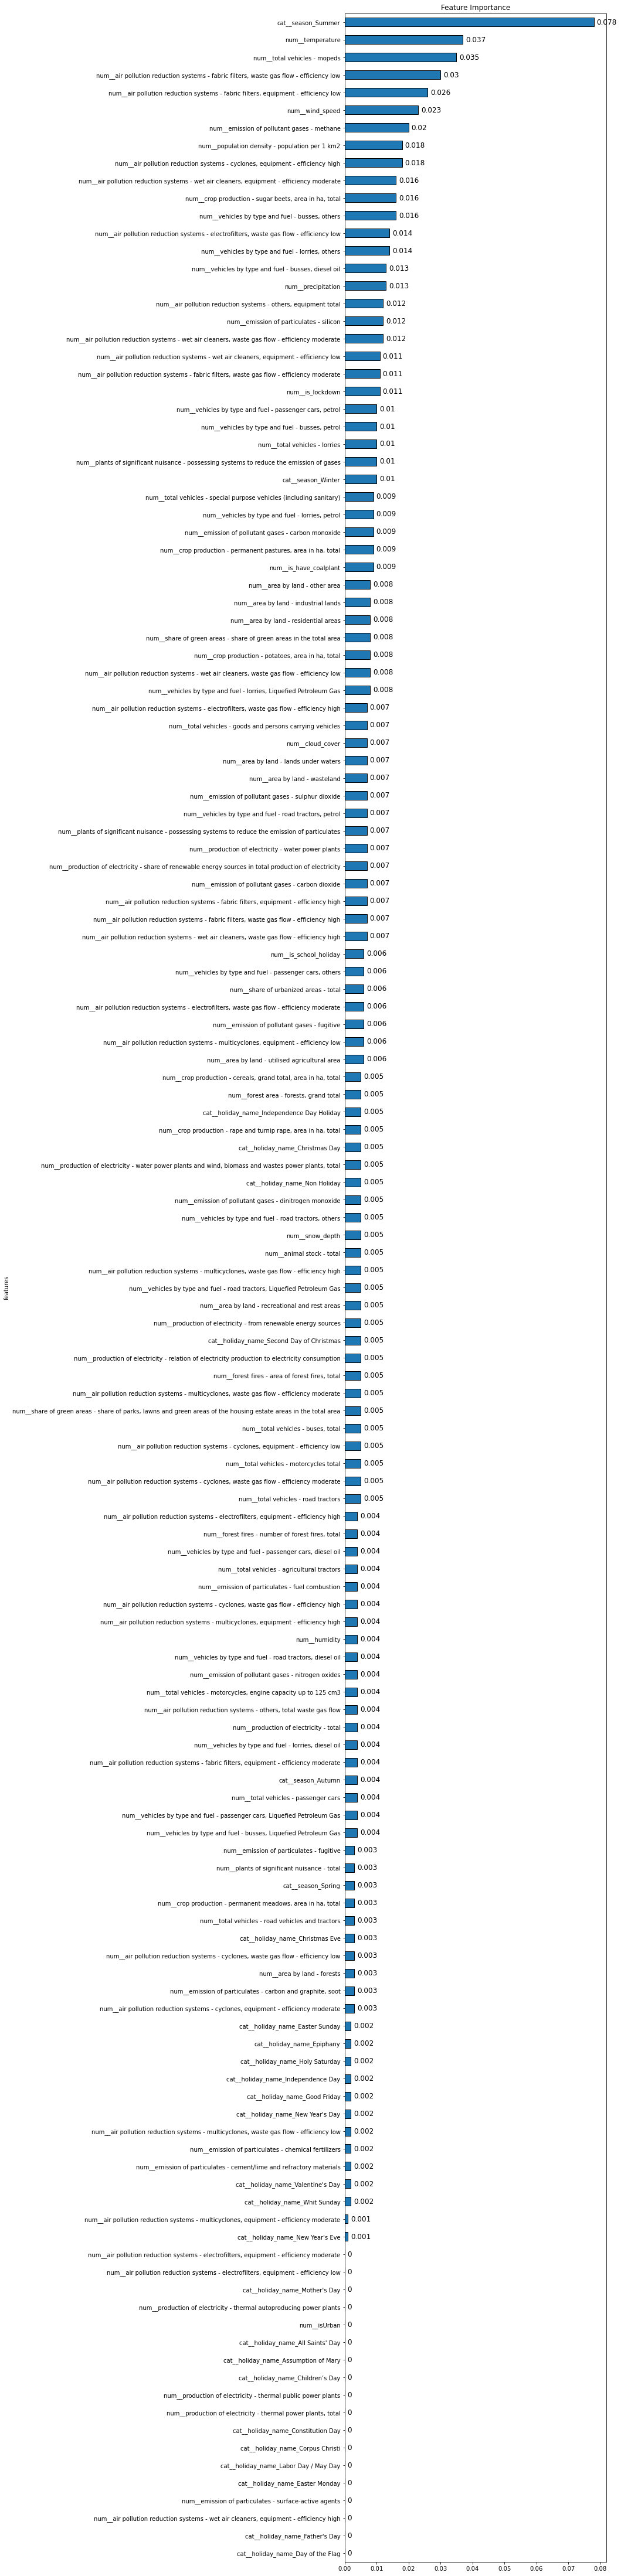

In [23]:
f_plot = feature_imp_df.plot(kind='barh', edgecolor='k', figsize=(8, 80))

f_plot.bar_label(ax.containers[0], fontsize = 12, padding = 5);
f_plot.legend().remove()
f_plot.set_title("Feature Importance");